- [ ] migrate minintake to postprocessing
- [ ] cut away domain borders (function to postprocessing)
- [ ] handle pl data
- [ ] domain mean hovmöller plot
- [ ] domain mean time series for warming experiment (like `00_preliminary/img/mean_timeseris_allvars.png`)
- [ ] more structure in this notebook

In [1]:
# make the notebook more readable:
import warnings
warnings.filterwarnings('ignore')
import sys
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path:
    sys.path.append(module_path)
import file_handling as fh

# Reproducibility of the original Eurec4a LES simulations

It sounds like a very modest project to rerun the Eurec4a simulations with the existing setup. But changes in the computing infrastructure forced me to recompile the model binary and results slightly changed. The idea was to:

1. compile ICON
2. replace grids and forcings by identical copies
3. *optional*: Add a prognostic Variable to help Jule in her Analysis (effective radius `reff`)
4. run for a short time


## The source code

#### Problem
The run script was constantly crashing and after sinking too much effort into getting my runscript to work, I finally got a debugging date with Hauke Schulz. He figured out, what we (Lukas Kluft and I) were already suspecting: **rttov** has been the root of my problems. I have tried: using the `icon-aes` main branch, using Haukes binary and using the `has-eurec4a-levante` branch (the branch Haukes binary was made of). All of these approaches failed. In the case of the old binary the only problem was a missing shared object (from a netcdf library). Hauke suggested recompiling, which should link a new, up to date library. 

#### Work around
So i copied Haukes directory and - with slight adaptions - recompiled the ICON there. Hauke wrote a Pad on [Reproducability of the ICON-simulation](https://pad.gwdg.de/qm4PfVpuRYCdM8BhXNPDUQ#ICON-model). Following this we:
1. copied the directory
3. reverted the last git commit which increased the aerosol concetrations (`git revert <commit_hash obtained by looking at the git log>`)
2. reseted the config (`make distclean`)
3. exported (mostly) RTTOV related environment variables
   ```
export LC_ALL="en_US.UTF-8"
export USE_RTTOV_13=true
export RTTOV_13_ROOT=/work/mh0010/m300408/DVC-test/rttov/rttov13/
export COMPILE_ICON_DEBUG=false
   ```
4. ran the config script
   ```
./config/dkrz/kamikaze.intel-2021.5.0-rttov --disable-ocean --disable-coupling --disable-jsbach --enable-rte-rrtmgp --enable-openmp
   ```
5. compiled (`make -j8`)
6. labeled the binary (`mv bin/icon "bin/icon_$(git_describe=$(git describe --dirty); echo ${git_describe: -7})"`)

The run script works with this binary.

#### Solution
Nevertheless, this work around has multiple problems:

 - Only in source builds seemed to work. Hauke overcomes some of the inconveniences of in source builds by relabeling the produced binary, appending a hash of the git commit it is based on.
 - I had to use Haukes version of the outdated *kamikaze* config script.
 - This working version only exists on levantes hard disk, not on any git. It is not even in sync with the outdated branch it is based on.

The out of source builds are a *nice to have*, but the other problems are a tad more serious. I would really like to make my run script work with the main `icon-aes` branch. Hauke said that this wouldn't include too many changes and suggested asking Robert Vicari for support, as he wrote much of the RTTOV code.

## How does the Data look like?

*edit: since the last time i touched this notebook, the data has been removed from disk and i had to adapt the script to work with the eurec4a intake catalog.*

My first proper rerun was limited by my runscript computation time limit of 30 minutes. I still got some output from the coarsest domain (`DOM01`), which ran roughly 30 minutes (coincidence). I since did a slightly longer rerun. Since they are (hopefully) somewhat identical, a short run should suffice.

In [2]:
import os
import xarray as xr
import eurec4a
import file_handling  as fh
import postprocessing as pp

def adress_of_haukes_postprocessing_script():
    return '/work/mh0010/m300408/covariability_les_obs/test/netcdf_to_objectstore_pipeline-Copy2.ipynb'

def get_data_pair(directory='/work/mh1126/m300872/eureca-icon_haukeremoterepo/EUREC4A/experiments/r02EUREC4A', match_timesteps=False):
    
    data = fh.MinIntake()
    data.control = fh.MinIntake()
    data.rerun = fh.MinIntake()
    
    keywords = ['DOM01', 'surf']
    c = fh.eureca_data_from_keywords(keywords)
    r = pp.clean_surface_data(fh.disk_data_from_keywords(directory, keywords))
    if match_timesteps: c,r = pp.time_overlap((c,r))
    data.control.surface = c
    data.rerun.surface   = r
    
    keywords = ['DOM01', '3D']
    c = fh.eureca_data_from_keywords(keywords)
    r = pp.clean_volume_data(fh.disk_data_from_keywords(directory, keywords))
    if match_timesteps: c,r = pp.time_overlap((c,r))
    data.control.volume = c
    data.rerun.volume   = r 
    
    keywords = ['DOM01', 'radiation']
    c = fh.eureca_data_from_keywords(keywords)
    r = pp.clean_volume_data(fh.disk_data_from_keywords(directory, keywords))
    if match_timesteps: c,r = pp.time_overlap((c,r))
    data.control.radiation = c
    data.rerun.radiation   = r 
    return data

data = get_data_pair()

### How much output is available?

In [3]:
for d, l in zip([data.control.surface, data.control.volume, data.rerun.surface, data.rerun.volume], 
                ['original 2D', 'original 3D', 'rerun 2D', 'rerun 3D']):
    print(l.ljust(12),':', d.dims)

original 2D  : Frozen({'time': 11809, 'cell': 4528560})
original 3D  : Frozen({'time': 328, 'cell': 4528560, 'height': 68, 'bnds': 2})
rerun 2D     : Frozen({'time': 85, 'cell': 4528560})
rerun 3D     : Frozen({'time': 2, 'cell': 4528560, 'height': 68, 'bnds': 2})


### Is the data identical?
How much is the maximum difference between the original and the rerun for each variable?

In [4]:
data = get_data_pair(match_timesteps=True)
for d, l in zip([data.control.surface, data.control.volume, data.rerun.surface, data.rerun.volume], 
                ['original 2D', 'original 3D', 'rerun 2D', 'rerun 3D']):
    print(l.ljust(12),':', d.dims)

original 2D  : Frozen({'time': 85, 'cell': 4528560})
original 3D  : Frozen({'time': 2, 'cell': 4528560, 'height': 68, 'bnds': 2})
rerun 2D     : Frozen({'time': 85, 'cell': 4528560})
rerun 3D     : Frozen({'time': 2, 'cell': 4528560, 'height': 68, 'bnds': 2})


In [5]:
def get_data_single(path, surface=True, radiation=True, volume=False, gridinfo=False):
    data = fh.MinIntake()
    
    keywords = ['DOM01', 'surf']
    if surface:
        d = pp.clean_surface_data(fh.disk_data_from_keywords(path, keywords))
        if gridinfo: d = pp.add_grid(d)
        data.surface = d
    
    keywords = ['DOM01', 'radiation']
    if radiation:
        d = pp.clean_volume_data( fh.disk_data_from_keywords(path, keywords))
        if gridinfo: d = pp.add_grid(d)
        data.radiation = d
    
    keywords = ['DOM01', '3D']
    if volume: 
        d = pp.clean_volume_data( fh.disk_data_from_keywords(path, keywords))
        if gridinfo: d = pp.add_grid(d) 
        data.volume = d

    return data
    
    
def warming_data(path='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/4kadiabat2'):
    return get_data_single(path=path)

warming_data()

In [6]:
# for var in list(data.rerun.surface):
#     if np.all(data.control.surface.mean(dim='cell')[var].values == data.rerun.surface.mean(dim='cell')[var].values):
#         print(var, 'identical')
#     else:
#         print(var, 'NOT IDENTICAL', f", max diff in domain mean: {np.nanmax(np.abs(data.control.surface.mean(dim='cell')[var].values - data.rerun.surface.mean(dim='cell')[var].values))}")

```
u_10m NOT IDENTICAL , max diff in domain mean: 0.0010609626770019531
v_10m NOT IDENTICAL , max diff in domain mean: inf
rh_2m NOT IDENTICAL , max diff in domain mean: inf
t_2m NOT IDENTICAL , max diff in domain mean: inf
qv_2m NOT IDENTICAL , max diff in domain mean: inf
t_seasfc NOT IDENTICAL , max diff in domain mean: inf
shfl_s NOT IDENTICAL , max diff in domain mean: inf
lhfl_s NOT IDENTICAL , max diff in domain mean: inf
tqv_dia NOT IDENTICAL , max diff in domain mean: inf
tqc_dia NOT IDENTICAL , max diff in domain mean: inf
tqi_dia NOT IDENTICAL , max diff in domain mean: inf
rain_gsp_rate NOT IDENTICAL , max diff in domain mean: inf
tot_prec NOT IDENTICAL , max diff in domain mean: inf
clct NOT IDENTICAL , max diff in domain mean: inf
pres_sfc NOT IDENTICAL , max diff in domain mean: inf
```

Most of them are not identical. The absolute deviations are hard to assess. Let's see this as domain mean time series.

On variable names see [Easy Gems documentation](https://easy.gems.dkrz.de/DYAMOND/Summer/models/icon.html).

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def int_factorize(x, always_bigger=True):
    m = int(np.sqrt(x))
    n = int(x/m)
    if m*n < x and always_bigger : m += 1
    return m,n

def fig_all_domain_means(data, labels, kwargs=False, verbose=False):
    if not kwargs: kwargs = [dict() for d in data]
    m, n = int_factorize(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k)) 

    for i,var in enumerate(list(dmean[0])):
        ax = axs[positions[i]]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j}', end=', ')
            ax.plot(d[var], label=labels[j], **kwargs[j])
        ax.set_title(var)
        ax.legend()
    if verbose: print('done')
    return fig, ax

labels = ['original', 'rerun']
d   = [data.control.surface, data.rerun.surface]
# dmean = [dd.mean(dim='cell') for dd in d]
kwargs = [{'ls' : ':'}, dict()]

In [8]:
# fig, ax = fig_all_domain_means(dmean, labels, kwargs, verbose=True)
# # fig.savefig('./img/mean_timeseris_allvars.png')
# fig.show()

![](./img/mean_timeseris_allvars.png)

In [9]:
labels = ['original']
d   = [data.control.surface]
# dmean = [dd.mean(dim='cell') for dd in d]
# # kwargs = [{'ls' : ':'}, dict()]
# fig, ax = fig_all_domain_means(dmean, labels, kwargs, verbose=True)
# fig.savefig('./img/mean_timeseris_allvars_orig.png')
# fig.show()

![](./img/mean_timeseris_allvars_orig.png)

In [10]:
labels = ['warming']
d   = [warming_data().surface]
dmean = [dd.mean(dim='cell') for dd in d]

15  plots: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, done


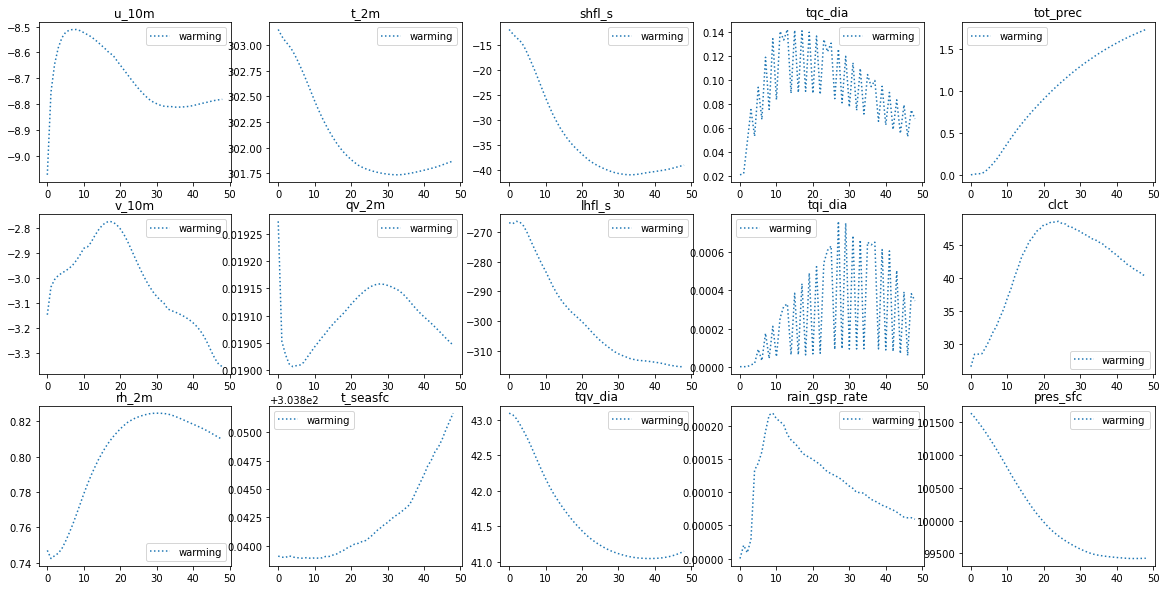

In [11]:
fig, ax = fig_all_domain_means(dmean, labels, kwargs, verbose=True)
fig.savefig('./img/mean_timeseris_allvars_warming.png')
fig.show()

![](./img/mean_timeseris_allvars_warming.png)

In [12]:
labels = ['original', 'warming']
d   = [data.control.surface, warming_data().surface]
# dmean = [dd.mean(dim='cell') for dd in d]
# fig, ax = fig_all_domain_means(dmean, labels, kwargs, verbose=True)
# fig.savefig('./img/mean_timeseris_allvars_orig_warm.png')
# fig.show()

![](./img/mean_timeseris_allvars_orig_warm.png)

In [13]:
def hf_rerun_data(path='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/rerun_03'):
    return get_data_single(path=path)

labels = ['original', 'rerun_hf']
d   = [data.control.surface, hf_rerun_data().surface]
# dmean = [dd.mean(dim='cell') for dd in d]
# fig, ax = fig_all_domain_means(dmean, labels, kwargs, verbose=True)
# fig.savefig('./img/mean_timeseris_allvars_orig_rerun03.png')
# fig.show()

![](./img/mean_timeseris_allvars_orig_rerun03.png)

In [14]:
w = warming_data()
tqv = w.surface['tqv_dia'].mean(dim='cell')
w.surface

<xarray.Dataset>
Dimensions:        (time: 49, cell: 4528560)
Coordinates:
  * time           (time) datetime64[ns] 2020-01-09T10:00:00 ... 2020-01-09T1...
  * cell           (cell) int64 0 1 2 3 4 ... 4528556 4528557 4528558 4528559
Data variables: (12/15)
    u_10m          (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    v_10m          (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    rh_2m          (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    t_2m           (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    qv_2m          (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    t_seasfc       (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    ...             ...
    tqc_dia        (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    tqi_dia        (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    rain_gsp_rate  (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    tot_prec       (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    clct           (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
    pres_sfc       (time, cell) float32 dask.array<chunksize=(1, 4528560), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               icon\tgit@gitlab.dkrz.de:icon/icon.git@e8171c42bcd2...
    history:              /work/mh1126/m300872/icon_haukestate//bin/icon-e817...
    references:           see MPIM/DWD publications
    comment:              Hernan Campos (m300872) on l40695 (Linux 4.18.0-348...

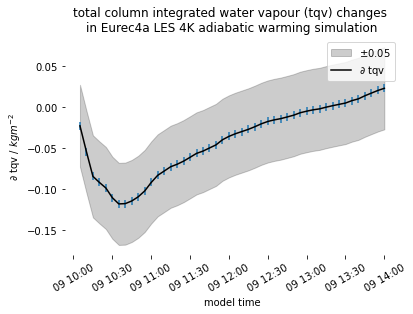

In [15]:
import plot_utils as pu

x = tqv.time.values
y = tqv.values
y = np.asarray([y[i] - y[i-1] for i in range(1,len(y))])
x = x[1::]

fig, ax = plt.subplots()
r = 0.05
ax.fill_between(x, y-r, y+r, alpha=0.2, color='black', label=f'$\pm {r}$')
ax.plot(x,y, color='black', label='$\partial$ tqv')
ax.scatter(x,y, s=50, marker='|')
pu.remove_spines(ax)
ax.set_xlabel('model time')
ax.set_ylabel('$\partial$ tqv / $kg m^{-2}$')
ax.set_title('total column integrated water vapour (tqv) changes \nin Eurec4a LES 4K adiabatic warming simulation')
ax.tick_params(axis="x", rotation=30)
ax.legend()
fig.savefig('img/tqv_timeseries_4kwarming.png')
fig.show()

In [16]:
tqv = hf_rerun_data().surface['tqv_dia'].mean(dim='cell')
x = tqv.time.values
y = tqv.values
y = np.asarray([y[i] - y[i-1] for i in range(1,len(y))])
x = x[1::]

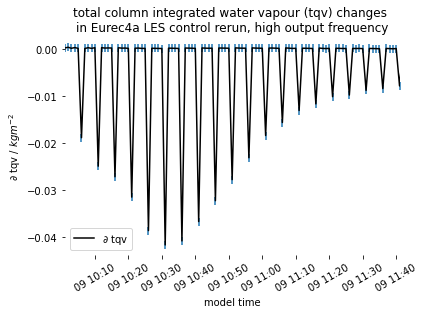

In [17]:
import plot_utils as pu

fig, ax = plt.subplots()
r = 0.05
# ax.fill_between(x, y-r, y+r, alpha=0.2, color='black', label=f'$\pm {r}$')
ax.plot(x,y, color='black', label='$\partial$ tqv')
ax.scatter(x,y, s=50, marker='|')
ax.set_xlim(x[200], x[250])
ax.set_xlim(x[0], x[100])
# ax.set_ylim(-0.01, 0.001)
pu.remove_spines(ax)
ax.set_xlabel('model time')
ax.set_ylabel('$\partial$ tqv / $kg m^{-2}$')
ax.set_title('total column integrated water vapour (tqv) changes \nin Eurec4a LES control rerun, high output frequency')
ax.tick_params(axis="x", rotation=30)
ax.legend()
# ax2 = ax.twinx()
# pu.remove_spines(ax2)

fig.savefig('img/tqv_timeseries_hf-rerun.png')
fig.show()

In [18]:
hf = hf_rerun_data().surface.mean(dim='cell')

In [19]:
def dt_timeseries(x,y):
    return np.asarray(x[1::]), np.asarray([y[i] - y[i-1] for i in range(1,len(y))])

def fetch_column_integrated_variables(dataset, labels=['tqc_dia', 'tqv_dia', 'tqi_dia'], dt=False):
    xys = list()
    for label in labels:
        x = dataset[label].time.values
        y = dataset[label].values
        if dt: x, y = dt_timeseries(x,y)
        xys.append((x,y))
    return xys, labels


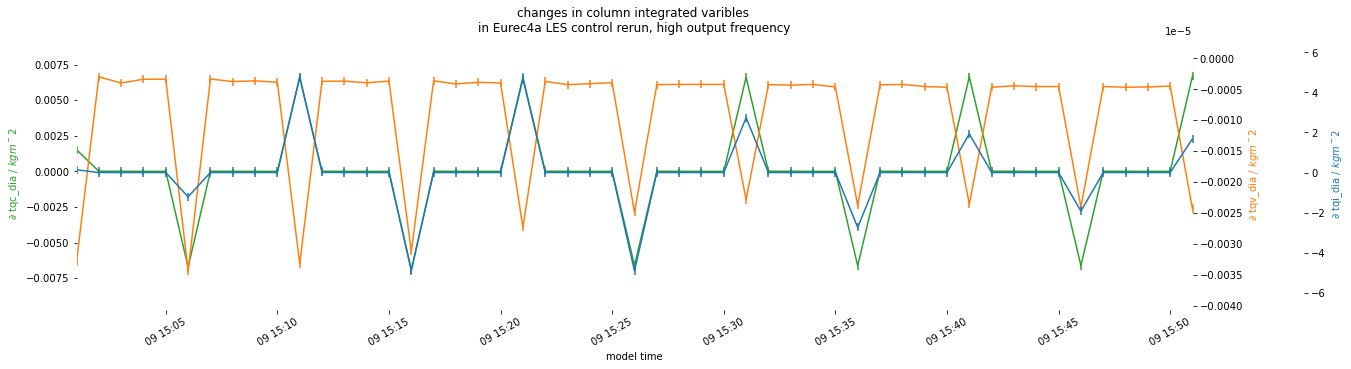

In [20]:
import plot_utils as pu

hf = hf_rerun_data().surface.mean(dim='cell')

def fig_zoom_on_pulses(timeseries, labels, colors=['tab:green', 'tab:orange', 'tab:blue'], xlim=(300,350)):
    fig, ax = plt.subplots(figsize=(20,5))
    axs = [ax, ax.twinx(), ax.twinx()]

    for ax, color, xy, label in zip(axs, colors, timeseries, labels):
        x, y = xy
        ax.plot(x,y, label=f'$\partial$ {label}', color=color)
        ax.scatter(x,y, s=50, marker='|', color=color)
        ax.yaxis.label.set_color(color)
        ax.set_ylabel(f'$\partial$ {label} / $kg m^{-2}$')
        r = (np.min(y[slice(*xlim)]), np.max(y[slice(*xlim)]))
        span = np.abs(r[0] - r[1]) * 0.2
        ax.set_ylim(r[0]-span, r[1]+span)

    ax = axs[0]
    ax.set_xlim(x[xlim[0]], x[xlim[1]])
    ax.set_xlabel('model time')
    ax.set_title('changes in column integrated varibles \nin Eurec4a LES control rerun, high output frequency')
    ax.tick_params(axis="x", rotation=30)
    # ax.legend()
    for ax in axs:
        pu.remove_spines(ax)
    for ax in axs[1::]:
        pass

    axs[-1].spines["right"].set_position(("axes", 1.1))
    return fig, axs

xys, labels = fetch_column_integrated_variables(hf, dt=True)
fig, axs = fig_zoom_on_pulses(xys, labels)
fig.savefig('img/tqvtqitqc_timeseries_hf-rerun.png')
fig.show()

In [21]:
72 * 1.3

93.60000000000001

In [22]:
hfr = hf_rerun_data().radiation.mean(dim='cell')
variables = ['sod_t', 'sou_t', 'sob_t']

rx, ry = dict(), dict()
for var in variables:
    x = hfr[var].time.values
    y = hfr[var].values
    ry[var] = np.asarray([y[i] - y[i-1] for i in range(1,len(y))])
    rx[var] = x[1::]


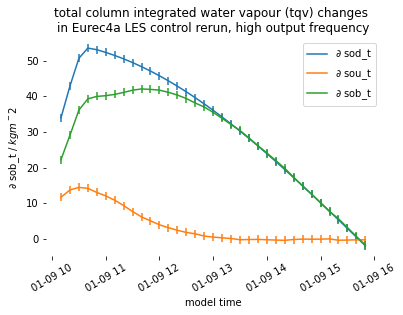

In [23]:
fig, ax = plt.subplots()

for var in rx.keys():
    x,y = rx[var], ry[var]
    # r = 0.05
    # ax.fill_between(x, y-r, y+r, alpha=0.2, color='black', label=f'$\pm {r}$')
    ax.plot(x,y, label=f'$\partial$ {var}')
    ax.scatter(x,y, s=50, marker='|')
    # ax.set_xlim(x[200], x[250])
    # ax.set_ylim(-0.01, 0.001)
    pu.remove_spines(ax)
    ax.set_xlabel('model time')
    ax.set_ylabel(f'$\partial$ {var} / $kg m^{-2}$')
    ax.set_title('total column integrated water vapour (tqv) changes \nin Eurec4a LES control rerun, high output frequency')
    ax.tick_params(axis="x", rotation=30)
ax.legend()
# ax2 = ax.twinx()
# pu.remove_spines(ax2)

fig.savefig('img/tqv_timeseries_hf-rerun.png')
fig.show()

### High freuqency Ouput runs

In [24]:
from sympy import isprime

param = ['dt_gwd', 'dt_sso', 'dt_rad', 'dt_conv', 'output_bounds']
ts = 6
mults = [i for i in range(20) if isprime(i)][0:len(param)]
for p,m in zip(param, mults):
    print(p.ljust(15),':', m*ts, f' ({m} * timestep)')

dt_gwd          : 12  (2 * timestep)
dt_sso          : 18  (3 * timestep)
dt_rad          : 30  (5 * timestep)
dt_conv         : 42  (7 * timestep)
output_bounds   : 66  (11 * timestep)


output_time_unit defaults to 1 (seconds)

ISO8601 time stamp for begin of output. An
example for this time stamp format is given
below. More than one value is possible in
order to define multiple start/end/interval
triples. See namelist parameter
output_bounds for an alternative
specification of output events.

output_end

ISO8601 time stamp for end of output. An
example for this time stamp format is given
below. More than one value is possible in
order to define multiple start/end/interval
triples. See namelist parameter
output_bounds for an alternative
specification of output events.

ISO8601 time stamp for repeating output
intervals. We choose the advection time step
matching or following the requested output
time, therefore we require
output_bounds(3) > dtime. An example
for this time stamp format is given below.
More than one value is possible in order to
define multiple start/end/interval triples.
See namelist parameter output_bounds for
an alternative specification of output events

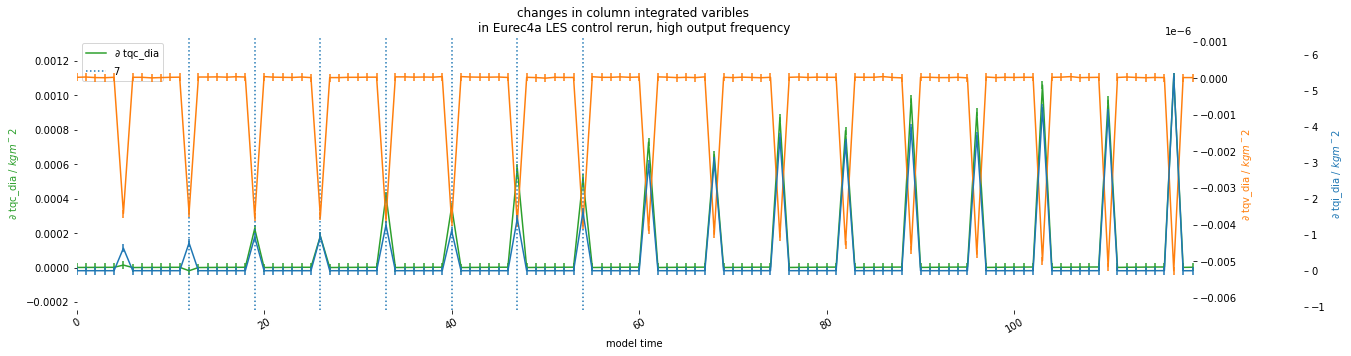

In [25]:
uhf_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/rerun_04_uhf'
# uhf_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/rerun_04_uhf-2'
uhf = get_data_single(path=uhf_path, radiation=False).surface.mean(dim='cell')
xys, labels = fetch_column_integrated_variables(uhf, dt=True)

xxyys = list()
for x, y in xys:
    xx = np.asarray(range(len(x)))
    xxyys.append((xx,y))
xys = xxyys

fig, axs = fig_zoom_on_pulses(xys, labels, xlim=(0,119))

mult, offset = 7, 5
axs[0].axvline(mult+offset, ls=':', label=str(mult))
for i in range(2,8):
    axs[0].axvline(mult*i+offset, ls=':')
axs[0].legend()

# fig.savefig('img/tqvtqitqc_timeseries_uhf-rerun.png')
fig.savefig('img/tqvtqitqc_timeseries_uhf-rerun.svg')
fig.show()

In [26]:
uhf_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/rerun_04_uhf'
uhf_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/rerun_04_uhf-2'
uhf_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/rerun_uhf-6'
uhf_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/rerun_uhf_07'


files = [os.path.join(uhf_path,f) for f in os.listdir(uhf_path) if 'surface' in f]
xr.open_mfdataset(files)

# uhf = get_data_single(path=uhf_path, radiation=False).surface.mean(dim='cell')
# xys, labels = fetch_column_integrated_variables(uhf, dt=True)

# xxyys = list()
# for x, y in xys:
#     xx = np.asarray(range(len(x)))
#     xxyys.append((xx,y))
# xys = xxyys

# fig, axs = fig_zoom_on_pulses(xys, labels, xlim=(0,119))

# mult, offset = 7, 5
# axs[0].axvline(mult+offset, ls=':', label=str(mult))
# for i in range(2,8):
#     axs[0].axvline(mult*i+offset, ls=':')
# axs[0].legend()

# fig.savefig('img/tqvtqitqc_timeseries_uhf-rerun.png')
# fig.show()

<xarray.Dataset>
Dimensions:        (height: 1, height_2: 1, time: 61, ncells: 4528560)
Coordinates:
  * height         (height) float64 10.0
  * height_2       (height_2) float64 2.0
  * time           (time) float64 2.02e+07 2.02e+07 ... 2.02e+07 2.02e+07
Dimensions without coordinates: ncells
Data variables: (12/15)
    u_10m          (time, height, ncells) float32 dask.array<chunksize=(10, 1, 4528560), meta=np.ndarray>
    v_10m          (time, height, ncells) float32 dask.array<chunksize=(10, 1, 4528560), meta=np.ndarray>
    rh_2m          (time, height_2, ncells) float32 dask.array<chunksize=(10, 1, 4528560), meta=np.ndarray>
    t_2m           (time, height_2, ncells) float32 dask.array<chunksize=(10, 1, 4528560), meta=np.ndarray>
    qv_2m          (time, height_2, ncells) float32 dask.array<chunksize=(10, 1, 4528560), meta=np.ndarray>
    t_seasfc       (time, ncells) float32 dask.array<chunksize=(10, 4528560), meta=np.ndarray>
    ...             ...
    tqc_dia        (time, ncells) float32 dask.array<chunksize=(10, 4528560), meta=np.ndarray>
    tqi_dia        (time, ncells) float32 dask.array<chunksize=(10, 4528560), meta=np.ndarray>
    rain_gsp_rate  (time, ncells) float32 dask.array<chunksize=(10, 4528560), meta=np.ndarray>
    tot_prec       (time, ncells) float32 dask.array<chunksize=(10, 4528560), meta=np.ndarray>
    clct           (time, ncells) float32 dask.array<chunksize=(10, 4528560), meta=np.ndarray>
    pres_sfc       (time, ncells) float32 dask.array<chunksize=(10, 4528560), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    number_of_grid_used:  99
    uuidOfHGrid:          6b59890b-99f3-939b-e76a-0a3ad2e43140
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    title:                ICON simulation
    source:               icon\tgit@gitlab.dkrz.de:icon/icon.git@e8171c42bcd2...
    history:              /work/mh1126/m300872/icon_haukestate//bin/icon-e817...
    references:           see MPIM/DWD publications
    comment:              Hernan Campos (m300872) on l30279 (Linux 4.18.0-348...

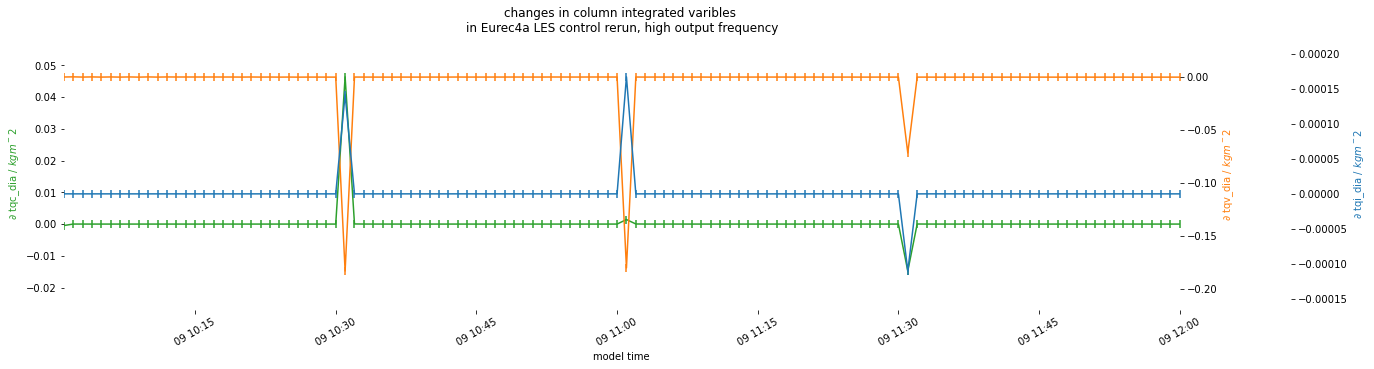

In [27]:
uhf_path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/rerun_05_dt_conv'
uhf = get_data_single(path=uhf_path, radiation=False).surface.mean(dim='cell')
xys, labels = fetch_column_integrated_variables(uhf, dt=True)


mult, offset, n = 1800/6, 5, 10
axs[0].axvline(mult+offset, ls=':', label=str(mult))
for i in range(2,n):
    axs[0].axvline(mult*i+offset, ls=':')
axs[0].legend()


fig, axs = fig_zoom_on_pulses(xys, labels, xlim=(0,len(xys[0][0])-1))
fig.savefig('img/tqvtqitqc_timeseries_rerun_longdtconv.png')
fig.show()

### Meteograms

Meteograms could be interesting. We are using Haukes function to extract a single station from the rather confusing meteogram format. We extract a station, trying *BCO* for a start.

In [28]:
# 'mext' taken from: 
# https://gitlab.gwdg.de/hernan.campos/EUREC4A-ICON/-/blob/levante_4k/EUREC4A/postprocessing/
import meteogram_extract_stations as mext
import xarray as xr
import numpy as np
import os
import eurec4a

station = 'BCO'

def meteogram_control(station):
    # has no temporal overlap with rerun
    cat = eurec4a.get_intake_catalog()
    return cat['simulations']['ICON']['LES_CampaignDomain_control'][f'meteogram_{station}_DOM02'].to_dask()

def meteogram_control(station,
        dirname = '/work/mh0010/m300408/DVC-test/EUREC4A-ICON/EUREC4A/experiments/EUREC4A/meteograms_lev0/',
        # this in the only file that has temporal overlap with my rerun. others start a day later.
        filename = 'Meteogram_445738_DOM01_patch001.nc',
        tempdir='/scratch/m/m300872/temp/',
        verbose=False):
    ifile = os.path.join(dirname, filename)
    ofile = os.path.join(tempdir, f'meteogram_{station}_{filename}')
    if verbose: print(ifile, '>>>', ofile)
    mext.create_ncfile(ifile, ofile, station=station, variables=None, verbose=verbose)
    return xr.open_dataset(ofile)

def meteogram_rerun(station,
        dirname='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/r02EUREC4A',
        filename='Meteogram_2052250_DOM01_patch001.nc',
        tempdir='/scratch/m/m300872/temp/',
        verbose=False):
    ifile = os.path.join(dirname, filename)
    ofile = os.path.join(tempdir, f'meteogram_{station}_rerun.nc')
    if verbose: print(ifile, '>>>', ofile)
    mext.create_ncfile(ifile, ofile, station=station, variables=None, verbose=verbose)
    return xr.open_dataset(ofile)

# def overlap_timesteps(datasets):
#     t = np.ravel(datasets[0].time.values)
#     for dataset in datasets[1::]:
#         t = [x for x in t if x in dataset.time.values]
#     return t

# def time_overlap(datasets):
#     t = overlap_timesteps(datasets)
#     return tuple([d.sel(time=t) for d in datasets])

# for met in [file_or, file_rr]:
#     print(met, os.path.basename(met)   , ': \n\t', mext.station_metadata(met))

In [29]:
met_or = meteogram_control('BCO')
met_rr = meteogram_rerun('BCO')
print(list(met_rr))

['time_step', 'date', 'P', 'T', 'PEXNER', 'RHO', 'THETAV', 'U', 'V', 'W', 'TKE', 'QV', 'QC', 'QI', 'QR', 'QS', 'REL_HUM', 'QG', 'QH', 'QNI', 'QNS', 'QNR', 'QNG', 'QNH', 'QNC', 'NIACT', 'QV_DIA', 'QC_DIA', 'QI_DIA', 'CLC', 'TKVM', 'TKVH', 'PHALF', 'T_SO', 'W_SO', 'W_SO_ICE', 'PL_COV', 'LA_IND', 'RO_DEPT', 'Z0', 'QV_S', 'W_I', 'W_SNOW', 'RUNOFF_S', 'RUNOFF_G', 'T_SNOW', 'T_S', 'T_G', 'FRESHSNW', 'RHO_SNOW', 'H_SNOW', 'FR_SEAICE', 'P_SFC', 'TCM', 'TCH', 'SHFL', 'LHFL', 'VIO3', 'HMO3', 'T2M', 'TD2M', 'U10M', 'V10M', 'VBMAX10M', 'dyn_gust', 'con_gust', 'cape_ml', 'SOBT', 'THBT', 'SOBS', 'THBS', 'ALB', 'RAIN_GSP', 'SNOW_GSP', 'RAIN_CON', 'SNOW_CON', 'H_ICE', 'CLCT', 'CLCL', 'CLCM', 'CLCH', 'hbas_con', 'htop_con', 'UMFL_S', 'VMFL_S', 'SWDIFU_S', 'SWDIFD_S', 'PAB_S', 'SWDIR_S', 'TQV', 'TQC', 'TQI', 'TQR', 'TQS', 'TQV_DIA', 'TQC_DIA', 'TQI_DIA']


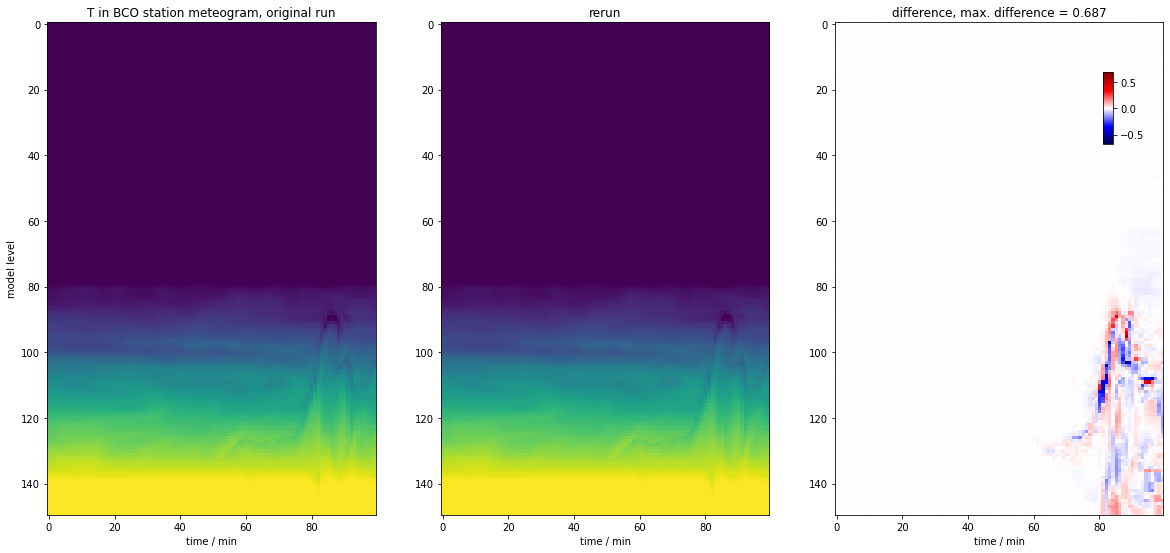

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import plot_utils as pu
import postprocessing as pp

var = 'T'
# var = 'QV'
met_or, met_rr = pp.time_overlap((met_or, met_rr))
diff  = met_rr[var].values - met_or[var].values


fig, axs = plt.subplots(1,3, figsize=(20,10))
ax = axs[0]
ax.set_title(f'{var} in BCO station meteogram, original run')
vmin, vmax = 270, 295
im = ax.imshow(met_or[var].values.transpose(), vmin=vmin, vmax=vmax)#, cmap='seismic')
ax.set_ylabel('model level')
ax.set_xlabel('time / min')
ax = axs[1]
ax.set_title(f'rerun')
im = ax.imshow(met_rr[var].values.transpose(), vmin=vmin, vmax=vmax)#, vmin=-vmax, vmax=vmax, cmap='seismic')
ax.set_xlabel('time / min')
ax = axs[2]
vmax = max(-np.min(diff), np.max(diff))
im = ax.imshow(diff.transpose(), vmin=-vmax, vmax=vmax, cmap='seismic')
ax.set_title(f'difference, max. difference = {vmax:.3f}')
# ax.set_ylabel('model level')
ax.set_xlabel('time / min')
inset_axes = inset_axes(ax,
                    width="3%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    borderpad=5,
                    loc=1)
# pu.remove_spines(inset_axes)
# pu.remove_ticks(inset_axes)
plt.colorbar(im, cax=inset_axes, ax=inset_axes)
fig.savefig('img/meteogram_bco_hovmoeller_diff.png')
fig.show()

We are interested in the variables that look fishy in our surface output: `tqc_dia`, `tqi_dia` and maybe `clct`. And these variables are also included in the station:

In [31]:
suspicous_list = ['tqc_dia', 'tqi_dia', 'clct']
for var in list(met_rr):
    for sus in suspicous_list:
        if sus in var.lower():
            print(f"{var} ({met_rr[var].long_name}) fits {sus}")

# bco_met

CLCT (total cloud cover) fits clct
TQC_DIA (total column integrated cloud water (diagnostic)) fits tqc_dia
TQI_DIA (total column integrated cloud ice (diagnostic)) fits tqi_dia


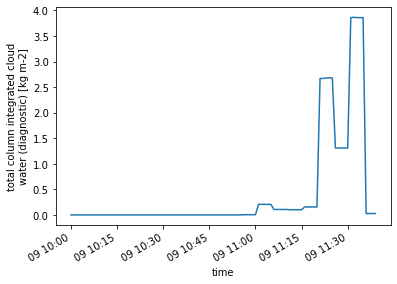

In [32]:
met_rr['TQC_DIA'].plot()

### Maps

12.0


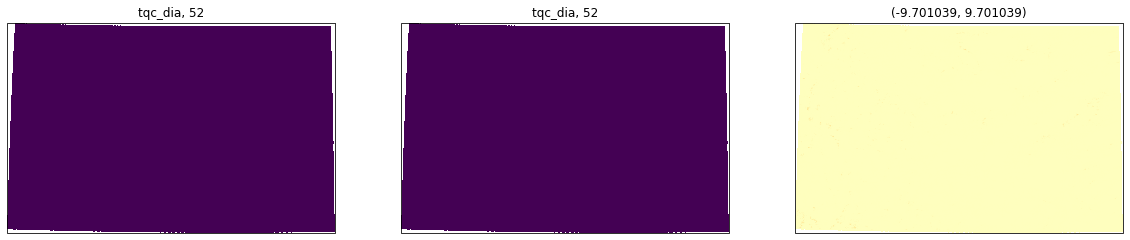

In [33]:
import pandas as pd
import datashader
from datashader.mpl_ext import dsshow
import cartopy.crs as ccrs
import cartopy.feature as cf
import eurec4a

def projection(viewpoint=(-50,10,1e08)):
    central_longitude, central_latitude, satellite_height = viewpoint
    return ccrs.NearsidePerspective(central_longitude=central_longitude, 
                                    central_latitude=central_latitude, 
                                    satellite_height=satellite_height)

def grid2coords(grid, proj=projection(), latlon_names=('clat', 'clon')):
    lat_name, lon_name = latlon_names
    return proj.transform_points(
        ccrs.Geodetic(),
        np.rad2deg(grid[lon_name]),
        np.rad2deg(grid[lat_name]), )

def add_map_plot(ax, data, vminmax=None, grid=pp.eurec4a_grid(), cmap='viridis', title = None, coastline = None):
    proj = projection()
    coords = grid2coords(pp.eurec4a_grid())
    if coastline: ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if not title: title = f"{var}, {t_index}"
    if vminmax:
        vmin, vmax = vminmax
    else:
        vmin = np.nanmin(data.values)
        vmax = np.nanmax(data.values)
        
    artist = dsshow(
        pd.DataFrame({
            "val": data.values,
            "x": coords[:, 0],
            "y": coords[:, 1],
        }),
        datashader.Point('x', 'y'),
        datashader.mean('val'),
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        ax=ax,
    )
    ax.set_title(title)
    return ax

def bipolar_vminmax(x):
    upper = np.abs(np.nanmax(x.values))
    lower = np.abs(np.nanmin(x.values))
    both  = np.max((upper, lower))
    return (-both, both)

rrun = data.rerun.surface
orig = data.control.surface

t_index = 52
var = 'tqi_dia'; cmap = 'viridis'
var = 'tqc_dia'; cmap = 'viridis'
# var = 'clct'; cmap = 'Blues'



fig = plt.figure(figsize=(20,10))
axs = list()
axs.append(fig.add_subplot(1,3,1, projection=projection()))
axs.append(fig.add_subplot(1,3,2, projection=projection()))
axs.append(fig.add_subplot(1,3,3, projection=projection()))
fig.canvas.draw_idle()

ax = axs[0]
r_snap = rrun[var].isel(time=t_index)
o_snap = orig[var].isel(time=t_index)
max_total = np.max(( np.abs(np.nanmax(r_snap.values)), np.abs(np.nanmax(o_snap.values)) ))
print(max_total)
vminmax = (0,max_total)
vminmax = (15,60)
add_map_plot(ax, o_snap, vminmax=vminmax, cmap=cmap)

ax = axs[1]
add_map_plot(ax, r_snap, vminmax=vminmax, cmap=cmap)

ax = axs[2]
diff = r_snap - o_snap
vminmax = bipolar_vminmax(diff)
add_map_plot(ax, diff, vminmax=vminmax, title=str(vminmax), cmap='Spectral')

plt.show()

In [34]:
ts = rrun['tqv_dia'].values
np.nanmin(ts), np.nanmax(ts)

(15.926305, 62.973286)

In [35]:
showstopper()

NameError: name 'showstopper' is not defined

In [ ]:
import pandas as pd
import postprocessing as pp

def fig_map_comparison(d, var, t_index=False, t_value=False, cmap='viridis', vminmax=False):
    if t_index: 
        d1 = d[0][var].isel(time=t_index)
        d2 = d[1][var].isel(time=t_index)
    elif t_value:
        d1 = d[0][var].sel(time=t_value)
        d2 = d[1][var].sel(time=t_value)
    else:
        raise ValueError(f'time identifier as input needed. use either t_index or t_value')
        
    fig = plt.figure(figsize=(20,10))
    axs = list()
    axs.append(fig.add_subplot(1,3,1, projection=projection()))
    axs.append(fig.add_subplot(1,3,2, projection=projection()))
    axs.append(fig.add_subplot(1,3,3, projection=projection()))
    fig.canvas.draw_idle()

    if not vminmax: vminmax = (0, np.max(( np.abs(np.nanmax(d1.values)), np.abs(np.nanmax(d2.values)) )))
    
    ax = axs[0]
    add_map_plot(ax, d1, vminmax=vminmax, cmap=cmap)
    ax.set_title(f'{var}, {pd.to_datetime(d1.time.values)}\ncontrol')
    ax = axs[1]
    add_map_plot(ax, d2, vminmax=vminmax, cmap=cmap)
    ax.set_title('rerun')

    ax = axs[2]
    diff = d1 - d2
    vminmax = (-max(vminmax), +max(vminmax))
    add_map_plot(ax, diff, vminmax=vminmax, cmap='bwr')
    ax.set_title('difference')

    return fig, axs


def generate_frames_map_comparison(d, var, timesteps=False, cmap='viridis', target_dir='img/'):
    file_list = list()
    if not timesteps: timesteps = pp.overlap_timesteps(d)
    for t in timesteps:
        fig, axs = fig_map_comparison(d, var, t_value=t, vminmax=(0,2), cmap=cmap)
        filename = os.path.join(target_dir, f'{var}_{str(t).rjust(2, "0")}.png')
        fig.savefig(filename)
        file_list.append(filename)
        plt.close(fig)
    return file_list


var = 'tqi_dia'; cmap = 'viridis'
var = 'tqc_dia'; cmap = 'viridis'
# var = 'clct'; cmap = 'Blues'

d = (data.control.surface, data.rerun.surface)
d = (data.control.radiation, data.rerun.radiation)

var = 'sob_t'; cmap = 'viridis'
print(len(pp.overlap_timesteps(d)))

# ff = generate_frames_map_comparison(d, var, cmap=cmap, timesteps=pp.overlap_timesteps(d)[0:50], target_dir='/scratch/m/m300872/temp')

![](img/clct_diff.gif)

In [ ]:
# ff += generate_frames_map_comparison(d, var, cmap=cmap, timesteps=pp.overlap_timesteps(d)[50::], target_dir='/scratch/m/m300872/temp')

In [ ]:
# ff = [os.path.join('/scratch/m/m300872/temp', f) for f in os.listdir('/scratch/m/m300872/temp') if 'clct_2020' in f]

In [ ]:
# showstopper()

In [ ]:
data.control.radiation

In [ ]:
# ff.sort()

In [ ]:
# import plot_utils as pu

# ff.sort()
# # for f in ff:
# #     print(f)
# pu.gif_from_image_list(ff, f'img/{var}_diff.gif')

![](img/tqc_dia_diff.gif)

In [ ]:
showstopper()

In [ ]:
list(data.control)

In [ ]:
import datetime

def icon2datetime(icon_dates):
    """
    From: esm_analysis lib
    Convert datetime objects in icon format to python datetime objects.
    :param icon_dates: collection
    :return dates:  pd.DatetimeIndex
    icon_dates i.e
        time = icon2datetime([20011201.5])
    """
    try:
        icon_dates = icon_dates.values
    except AttributeError:
        pass

    try:
        icon_dates = icon_dates[:]
    except TypeError:
        icon_dates = np.array([icon_dates])

    def _convert(icon_date):
        frac_day, date = np.modf(icon_date)
        frac_day *= 60 ** 2 * 24
        date = str(int(date))
        date_str = datetime.datetime.strptime(date, '%Y%m%d')
        td = datetime.timedelta(seconds=int(frac_day.round(0)))
        return date_str + td

    conv = np.vectorize(_convert)
    try:
        out = conv(icon_dates)
    except TypeError:
        out = icon_dates
    if len(out) == 1:
        return pd.DatetimeIndex(out)[0]
    return pd.DatetimeIndex(out)

In [ ]:
import pandas as pd
import datashader
from datashader.mpl_ext import dsshow
import cartopy.crs as ccrs
import cartopy.feature as cf

def projection(viewpoint=(-50,10,1e08)):
    central_longitude, central_latitude, satellite_height = viewpoint
    return ccrs.NearsidePerspective(central_longitude=central_longitude, 
                                    central_latitude=central_latitude, 
                                    satellite_height=satellite_height)

def grid2coords(grid, proj=projection(), latlon_names=('clat', 'clon')):
    lat_name, lon_name = latlon_names
    return proj.transform_points(
        ccrs.Geodetic(),
        np.rad2deg(grid[lon_name]),
        np.rad2deg(grid[lat_name]), )

def add_map_plot(ax, data, vminmax=None, grid=eurec4a_grid(), cmap='viridis', title = None, coastline = None):
    proj = projection()
    coords = grid2coords(eurec4a_grid())
    if coastline: ax.add_feature(cf.COASTLINE, linewidth=0.8)
    if not title: title = f"{var}"
    if vminmax:
        vmin, vmax = vminmax
    else:
        vmin = np.nanmin(data.values)
        vmax = np.nanmax(data.values)
        
    artist = dsshow(
        pd.DataFrame({
            "val": data.values,
            "x": coords[:, 0],
            "y": coords[:, 1],
        }),
        datashader.Point('x', 'y'),
        datashader.mean('val'),
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        ax=ax,
    )
    ax.set_title(title)
    return ax

def bipolar_vminmax(x):
    upper = np.abs(np.nanmax(x.values))
    lower = np.abs(np.nanmin(x.values))
    both  = np.max((upper, lower))
    return (-both, both)

def map_succession(data, var, t_start, M, N, cmap='viridis', vminmax=None,
                   title = None, verbose = False, proj=projection()):
    if t_start + (M*N) > len(data.time.values): raise ValueError('t_start chosen too small for grid dimensions.')
    fig = plt.figure(figsize=(20,10))
    fig.canvas.draw_idle()
    axs = list()
    for n in range(N):
        for m in range(M):
            i = (m + n*M + 1)
            # if verbose: print(m,n,i)
            if verbose: print(i, end=',')
            ax = fig.add_subplot(M, N, i, projection=proj)
            fig.canvas.draw_idle()
            d_sel = data[var].isel(time=(t_start + i - 1))
            title = f"{var}, {icon2datetime(data.time.values)[t_start + i - 1]}"
            add_map_plot(ax, d_sel, title=title, cmap=cmap, vminmax=vminmax)
            axs.append(ax)
    return fig, axs

t_start = 30
var = 'clct'; cmap = 'Blues'
M, N = 3, 3
# data = rrun
title = None
verbose = True
proj=projection()

fig, axs = map_succession(rrun, var, t_start, M, N, cmap=cmap, verbose=verbose)
plt.show()

In [ ]:
t_start = 60
var = 'tqi_dia'; cmap = 'viridis'
var = 'tqc_dia'; cmap = 'viridis'
vminmax=(0,0.4)
fig, axs = map_succession(rrun, var, t_start, M, N, cmap=cmap, verbose=verbose, vminmax=vminmax)
plt.show()

        # title = f"NaN count: {np.count_nonzero(np.isnan(data.values))}"
        # print(type(data),type(data.values))
        # print('non zero count: ',np.count_nonzero(data.values))
        # print('zero count: ',np.count_nonzero(data.values==0))
        # print('NaN count: ',np.count_nonzero(np.isnan(data.values)))
        # print('inf count: ',np.count_nonzero(np.isinf(data.values)))
        
        # ax.plot(np.linspace(0,1,5),np.sin(np.linspace(0,1,5)))

Not very suspicious. But without specifying a color interval (`vmin, vmax = 0, 0.4`) the plot is barely visible, because automatic interval detection assigns a much larger vmax (>10). This could hint to large outlyers. We will look into outliers, but first:

### Are `Nan` entries responsible for the oscillating domain mean time series?
How does the number of `NaN` look as a time series for each variable?
<!-- Back to the domain mean time series [at the start of this notebook](#is-the-data-identical). -->

In [ ]:
import matplotlib.pyplot as plt

def count_nan(x):
    return np.count_nonzero(np.isnan(x))

def fig_all_domain_means(a, b, a_label='original', b_label='rerun'):
    m, n = int_factorize(len(list(a)))
    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k))
        
    for i,var in enumerate(list(a)):
        ax = axs[positions[i]]
        a_nan_series = [count_nan(a[var].isel(time=t).values) for t in range(len(a.time.values))]
        b_nan_series = [count_nan(b[var].isel(time=t).values) for t in range(len(a.time.values))]
        # print(aa)
        ax.plot(a_nan_series, label='original', ls=':')
        ax.plot(b_nan_series, label='rerun')
        ax.set_title(var)
        ax.set_ylim(0,60000)
        ax.legend()
    return fig, ax

fig, ax = fig_all_domain_means(orig, rrun)
plt.show()

In [ ]:
t = 0
print(f'percentage of `NaN` at t={t}:', 100 * count_nan(rrun[var].isel(time=t).values)/len(eurec4a_grid().cell.values),'%')

Not very interesting, except, that the orginal data apparently has one data point without any `NaN`. 

### Outlier
How to assess outliers? We could check a histogram or take a look at quantiles. But first we are going to check the median, because it should be more robust to outliers. We will pick the variable `tqi_dia` because it showed a clear oscillation. 

In [ ]:
def fig_all_domain_medians(a, b, a_label='original', b_label='rerun'):
    a = a.median(dim='cell')
    b = b.median(dim='cell')
    m, n = int_factorize(len(list(a)))

    fig,axs = plt.subplots(m,n, figsize=(20,10))

    positions = list()
    for k in range(n):
        for i in range(m):
            positions.append((i,k))

    for i,var in enumerate(list(a)):
        ax = axs[positions[i]]
        # not showing, because the one time without NaN step ruins the plot
        # ax.plot(a[var], label='original', ls=':')
        ax.plot(b[var], label='rerun')
        ax.set_title(var)
        ax.legend()
    return fig, ax

fig, ax = fig_all_domain_medians(orig, rrun)
plt.show()

The domain median for the whole time series of the variables `tqc_dia`, `tqi_dia`, `clct` and `rain_gsp_rate` is zero. This means that most of the values in the domain are always zero.

In [ ]:
def remove_spines(ax, borders=['top','bottom','left','right']):    
    for border in borders:
        ax.spines[border].set_visible(False)
    return ax
          
def remove_ticks(ax, borders=['left','right','bottom']):
    left, right, bottom, labelleft, labelbottom = True, True, True, True, True
    if 'left'   in borders: left = False; labelleft = False
    if 'right'  in borders: right = False
    if 'bottom' in borders: bottom = False; labelbottom = False
    ax.tick_params(left=left, right=right, bottom=bottom, 
                   labelleft=labelleft, labelbottom=labelbottom)
    return ax
    
def plot_quantiles(data, quantiles=[0.5, 0.5, 0.95]):
    fig, axs =  plt.subplots(1,len(quantiles), 
                             figsize=(5*len(quantiles) ,3))
    i=0
    axs[i].set_xlabel('output time step')
    for q in quantiles:
        axs[i].plot(data.quantile(q,   dim='cell'), label=f"Q {q}")
        axs[i].legend()
        remove_spines(axs[i])
        i+=1
    # axs[0].get_shared_y_axes().join(*axs)
    return fig, axs


var = 'tqi_dia'
data = rrun[var]    
title = var + ' quantile time series'
quantiles = [0.7, 0.975, 0.985, 0.995, 0.999, 0.9995]
quantiles = [0.5, 0.7, 0.8, 0.9, 0.95, 0.99]
fig, axs = plot_quantiles(data, quantiles)
fig.suptitle(title)
# axs[0].plot(data.mean(dim='cell'), label='mean')
axs[0].legend()
plt.show()

Apparently in all time steps most of the values equal zero. 

In [ ]:
fig, ax =  plt.subplots()
fig.suptitle(var)
ax.plot(data.where(data == 0.0).count(dim='cell') / len(data.cell.values), color='black')
ax.set_xlabel('output time step')
ax.set_ylabel('fraction of values == 0.0')
ax.axhline(0.95, color='red', ls=':')
remove_spines(ax)
plt.show()

How do histograms for the spatial variation of the variables in question look for a specific time step?

In [ ]:
def plot_loghist(ax, x, **kwargs):
    hist, bins = np.histogram(x, **kwargs)
    logbins = np.logspace(np.log10(bins[-1]/1000),np.log10(bins[-1]),len(bins))
    ax.hist(x, bins=logbins, color='red')
    ax.set_xscale('log')
    return ax

def fig_variables_histograms_at_t(data, varset, t):
    fig, axss = plt.subplots(len(varset),3, figsize=(20,10))
    fig.canvas.draw_idle()
    fig.suptitle(icon2datetime(data.time.values)[t])

    for i, axs in enumerate(axss):
        var = varset[i]
        snapshot = data[var].isel(time=t).values
        snapshot = snapshot[~np.isnan(snapshot)] 

        axs[0].set_title(var)
        axs[0].plot(snapshot, color='black', lw=0.1)
        axs[1].hist(snapshot, bins=100, color='red')
        axs[2] = plot_loghist(axs[2], snapshot, bins=100)
        if i == (len(axss)-1):
            axs[2].set_xlabel('log histogram')
            axs[1].set_xlabel('linear histogram')
            axs[0].set_xlabel('cell')
        for ax in axs:
            remove_spines(ax)

varset = ['tqi_dia', 'tqc_dia', 'clct', 'rain_gsp_rate']
var = np.random.choice(varset)
t = np.random.randint(85)
data = rrun
fig_variables_histograms_at_t(data, varset, t)
plt.show()

Rather let us look at histograms for every time step over the oscillations. 

In [ ]:
def fig_histogram_for_timesteps(data, n_timesteps, t_0):
    fig, axs = plt.subplots(n_timesteps,2, figsize=(15,3*n_timesteps))
    
    for i in range(n_timesteps):
        snapshot = data.isel(time=t_0+i).values
        snapshot = snapshot[~np.isnan(snapshot)] 

        ax=axs[i,0]
        ax.set_title(icon2datetime(data.time.values)[t_0+i])
        ax.plot(snapshot, color='black', lw=0.1)
        ax.set_ylim(0,1)
        remove_spines(ax)
        
        ax=axs[i,1]
        ax = plot_loghist(ax, snapshot, bins=100, range=(1e-5,1e0))
        ax.set_ylim(0,100)
        remove_spines(ax)

    
    axs[ 0,1].set_title(f"{var}, starting {icon2datetime(data.time.values)[t_0]}(i={t_0})")
    axs[-1,1].set_xlabel('log histogram')
    axs[-1,0].set_xlabel('cell')
    return fig, axs


varset = ['tqi_dia', 'tqc_dia', 'clct', 'rain_gsp_rate']
var = np.random.choice(varset)
t_end = len(data.time.values) - 1
t_0 = np.random.randint(t_end - M)

# enough random. this selection shows the problem:
var = 'tqi_dia'
t_0 = 66
n_timesteps=6
data = rrun[var]

fig, axs = fig_histogram_for_timesteps(data, n_timesteps, t_0)
fig.suptitle(f"{var}, starting {icon2datetime(data.time.values)[t_0]}(i={t_0})")
# plt.savefig(f"{var}_{t_0}-{t_0+M}.pdf")
plt.show()

Now this looks like cloud ice is actually appearing and disappearing. And it is in the higher end of the distribution, meaning in a few cells high amounts of cloud ice are periodically appearing and disappearing. This is bad. Maybe these cells are at the edge of the domain. Let's see where they are.

In [ ]:
data = rrun
var = 'tqi_dia'
t = 67
t = 69
t = 71
threshold = 0.1

snapshot = data[var].isel(time=t).values
snapshot = snapshot[~np.isnan(snapshot)] 

fig, axs = plt.subplots(1,3, figsize=(20,6))
axs[0].plot(snapshot, label=f"{var}", color='black', lw=0.1)
axs[0].set_xlabel('cell number')
axs[0].axhline(threshold, ls=':', label='threshold')
axs[0].legend()
axs[0].set_title(icon2datetime(data.time.values)[t])

field = data[var].isel(time=t)
above_threshold= field.where(field>threshold)#.values

add_map_plot(axs[1], above_threshold, grid=eurec4a_grid(), title='map: grid points over threshold')
add_map_plot(axs[2], data[var].isel(time=t), grid=eurec4a_grid(), title=var, vminmax=(0,threshold/1000))

remove_ticks(axs[1])
remove_ticks(axs[2])
remove_spines(axs[0])
plt.show()

They appear to be right in the middle of the domain. Maybe they are at the upper limit of the domain. Time to look at 3D fields. At what timesteps is 3D data available?

In [ ]:
filelist_3d = [os.path.join(dir_rerun,f) for f in os.listdir(dir_rerun) if '3D' in f]
data_3d = xr.open_mfdataset(filelist_3d).rename({'ncells':'cell'})
timesteps_3d = icon2datetime(data_3d.time.values).values

data_surf = rrun
timesteps_surf = icon2datetime(data_surf.time.values).values

timesteps_with_3d_data = list()
for i, t in enumerate(timesteps_surf):
    if t in timesteps_3d: 
        print(i,t)
        timesteps_with_3d_data.append(i)

In [ ]:
data = rrun
var = 'tqi_dia'

for t in timesteps_with_3d_data:
    field = data[var].isel(time=t)
    above_threshold = field.where(field>threshold)
    # indices of cells above threshold:
    i_above = np.asarray(above_threshold.values>0).nonzero()[0]
    print(f"number of cells above threshold at t={t}: {len(i_above)}")

In [ ]:
print('available variables in the 3D output:')
for v in list(data_3d):
    try: 
        print(f"   {v.ljust(12)}:  {data_3d[v].long_name}")
    except:
        pass

No cloud ice in there. So I have two time steps for cloud water left. Is there anything strange in these time steps?

In [ ]:
def fig_histogram_for_timestep(data, t):
    fig, axs = plt.subplots(2,1, figsize=(15,5))
    
    snapshot = data.isel(time=t).values
    snapshot = snapshot[~np.isnan(snapshot)] 

    ax=axs[0]
    ax.set_title(icon2datetime(data.time.values)[t])
    ax.plot(snapshot, color='black', lw=0.1)
    remove_spines(ax)

    ax=axs[1]
    ax = plot_loghist(ax, snapshot, bins=100)
    remove_spines(ax)

    axs[1].set_title(f"{var}, starting {icon2datetime(data.time.values)[t]}(i={t})")
    axs[1].set_xlabel('log histogram')
    axs[0].set_xlabel('cell')
    return fig, axs


data = rrun[var]
var = 'tqv_dia'
t = 60

fig, axs = fig_histogram_for_timestep(data, t)
fig.suptitle(f"{var}, starting {icon2datetime(data.time.values)[t]}(i={t})")
plt.show()

In [ ]:
t = 24
fig, axs = fig_histogram_for_timestep(data, t)
fig.suptitle(f"{var}, starting {icon2datetime(data.time.values)[t]}(i={t})")
plt.show()

In [ ]:
def fig_above_threshold_map(data, t):
    snapshot = data.isel(time=t).values
    snapshot = snapshot[~np.isnan(snapshot)] 

    threshold = np.quantile(snapshot, 0.9999)

    fig, axs = plt.subplots(1,3, figsize=(20,6))
    axs[0].plot(snapshot, color='black', lw=0.2)
    axs[0].set_xlabel('cell number')
    axs[0].axhline(threshold, ls=':', label='threshold', color='red')
    axs[0].legend()
    axs[0].set_title(icon2datetime(data.time.values)[t])

    field = data.isel(time=t)
    above_threshold= field.where(field>threshold)#.values

    add_map_plot(axs[1], above_threshold, grid=eurec4a_grid(), title='map: grid points over threshold')
    add_map_plot(axs[2], data.isel(time=t), grid=eurec4a_grid(), title=var, 
                 vminmax=(np.quantile(snapshot, 0.0001),np.quantile(snapshot, 0.9999)))

    remove_ticks(axs[1])
    remove_ticks(axs[2])
    remove_spines(axs[0])
    return fig, axs

fig_above_threshold_map(data, 24)
plt.show()

In [ ]:
fig_above_threshold_map(data, 60)
plt.show()

## Comparison of BCO Meteogram

In [ ]:
def timeseries_control():
    cat = eurec4a.get_intake_catalog()
    surf = cat['simulations']['ICON']['LES_CampaignDomain_control']['surface_DOM01'].to_dask()
    return surf.mean(dim='cell')

var = 'clct'
tct = timeseries_control()
series  = tct[var]
fig, ax = plt.subplots()
ax.plot(surf.time.values, series)
fig.show()

In [ ]:
def masked_file_list(directory, mask):
    return [os.path.join(directory, f) for f in fh.get_filelist(directory) if mask in f]


def dataset_from_directory(directory, mask = 'DOM01_surf', rename_dict={'ncells':'cell'}, convert_time=True, clear_dims=False):
    data = xr.open_mfdataset(masked_file_list(directory, mask))
    if rename_dict: data = data.rename(rename_dict)
    print(data.time.values.shape)
    print(fh.icontime2numpytime(data.time.values[0]))
    if convert_time: data = data.assign_coords({"time": [fh.icontime2numpytime(t) for t in data.time.values]})
    if clear_dims:   data = remove_dims(data, clear_dims)
    return data.rename()

def timeseries_rerun(dirname='/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/r02EUREC4A'):
    return dataset_from_directory(dirname).mean(dim='cell')
    
trr = timeseries_rerun()

In [ ]:
import random

ct, rr = time_overlap((tct,trr))
var = random.choice(list(ct))
print(list(ct))

fig, ax = plt.subplots()
ax.plot(ct.time.values, ct[var].values, label='control')
ax.plot(rr.time.values, rr[var].values, label='rerun', ls=':')
ax.set_ylabel(var)
ax.set_xlabel('model time')
ax.legend()
plt.show()

In [ ]:
ct